2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하차총승객수)

In [1]:
# 내장 라이브러리
import datetime
import glob
import pathlib

# 외부 라이브러리
import pandas as pd
import pandas.io.formats.format as pf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
import folium.plugins


pd.options.display.float_format = '{:0,.2f}'.format

sns.set_palette('husl')
sns.set_style('whitegrid')

plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False

DAY_OF_WEEK = ['월', '화', '수', '목', '금', '토', '일']
DAY_OF_WEEK_MAPPER = {i: day for i, day in enumerate(DAY_OF_WEEK)}
HOLIDAYS = {
    datetime.date(2019, 1, 1): "신정",
    datetime.date(2019, 2, 4): "설날(연휴)",
    datetime.date(2019, 2, 5): "설날",
    datetime.date(2019, 2, 6): "설날(연휴)",
    datetime.date(2019, 3, 1): "삼일절",
    datetime.date(2019, 5, 5): "어린이날",
    datetime.date(2019, 5, 6): "(어린이날)대체휴일",
    datetime.date(2019, 5, 12): "부처님오신날",
    datetime.date(2019, 6, 6): "현충일",
    datetime.date(2019, 8, 15): "광복절",
    datetime.date(2019, 9, 12): "추석(연휴)",
    datetime.date(2019, 9, 13): "추석",
    datetime.date(2019, 9, 14): "추석(연휴)",
    datetime.date(2019, 10, 3): "개천절",
    datetime.date(2019, 10, 9): "한글날",
    datetime.date(2019, 12, 25): "크리스마스",
}

BASE_DIR = pathlib.Path('../').resolve()
CSV_FILES = glob.glob(str(BASE_DIR / '실습' / 'rawfiles' / 'CARD_SUBWAY_MONTH_*.csv'))

print('Files:\n'+'\n'.join(CSV_FILES)+'\n')

Files:
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201903.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201902.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201901.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201905.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201904.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201906.csv



In [2]:
def get_raw_df(files: list = CSV_FILES) -> pd.DataFrame:
    return pd.concat([pd.read_csv(filename) for filename in files])


print(get_raw_df().info())
get_raw_df().head()

<class 'pandas.core.frame.DataFrame'>
Index: 107028 entries, 0 to 17723
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   사용일자    107028 non-null  int64  
 1   노선명     107028 non-null  object 
 2   역명      107028 non-null  object 
 3   승차총승객수  107028 non-null  float64
 4   하차총승객수  107028 non-null  float64
 5   등록일자    107028 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB
None


,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,20190301,4호선,서울역,"62,588.00","64,794.00",20190304
1,20190301,1호선,신설동,"1,335.00","1,375.00",20190304
2,20190301,6호선,보문,"1,208.00","1,271.00",20190304
3,20190301,4호선,성신여대입구,"3,231.00","3,650.00",20190304
4,20190301,우이신설경전철,정릉,"3,620.00","2,869.00",20190304


In [3]:
def get_df() -> pd.DataFrame:
    df = get_raw_df()
    df['사용일자'] = pd.to_datetime(df['사용일자'], format='%Y%m%d')
    df['주차'] = df['사용일자'].dt.dayofyear//7+1
    df['요일'] = df['사용일자'].dt.dayofweek.map(DAY_OF_WEEK_MAPPER)
    df['월'] = df['사용일자'].dt.month.astype(int)
    df['일'] = df['사용일자'].dt.day.astype(int)
    df['승하차총승객수'] = df['승차총승객수'] + df['하차총승객수']
    df['공휴일'] = df['사용일자'].dt.date.isin(HOLIDAYS.keys())
    return df.groupby(['사용일자']) \
        .aggregate({
            '승하차총승객수': 'sum',
            '월': 'first',
            '일': 'first',
            '주차': 'first',
            '공휴일': 'first',
            '요일': 'first',
        }) \
        .reset_index()


np.random.seed(1)
get_df().sample(10)

,사용일자,승하차총승객수,월,일,주차,공휴일,요일
117,2019-04-28,"10,233,554.00",4,28,17,False,일
93,2019-04-04,"17,171,190.00",4,4,14,False,목
113,2019-04-24,"16,973,170.00",4,24,17,False,수
162,2019-06-12,"16,846,068.00",6,12,24,False,수
35,2019-02-05,"5,652,814.00",2,5,6,True,화
54,2019-02-24,"9,937,640.00",2,24,8,False,일
69,2019-03-11,"16,738,261.00",3,11,11,False,월
19,2019-01-20,"9,029,923.00",1,20,3,False,일
125,2019-05-06,"10,709,298.00",5,6,19,True,월
150,2019-05-31,"17,726,946.00",5,31,22,False,금


In [4]:
# 2019년 5월 5일은 일요일이다.

df = get_df()
df[df['사용일자'].dt.date == datetime.date(2019, 5, 5)]

,사용일자,승하차총승객수,월,일,주차,공휴일,요일
124,2019-05-05,"10,560,843.00",5,5,18,True,일


### 4. 연월 각각에 대해 일자별(월일별) 승하차총승객수 그래프 그려 볼까요? (pointplot)

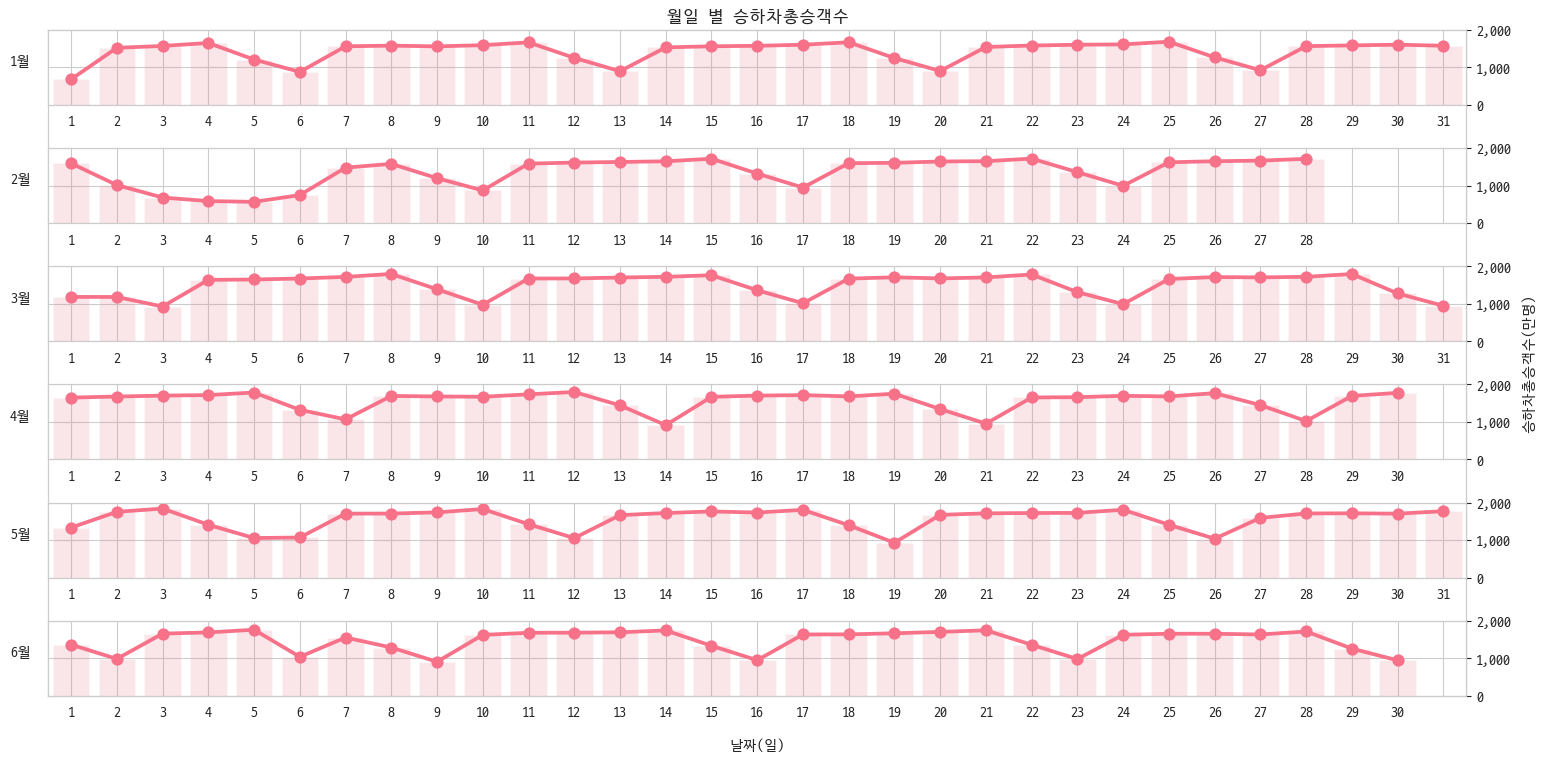

In [5]:
plt.figure(figsize=(16, 8))

# 가장 바깥 플롯에 표시할 내용
plt.title('월일 별 승하차총승객수')
plt.xlabel('날짜(일)', labelpad=30)
plt.xticks([])
plt.yticks([])

ax = plt.twinx()
ax.set_yticks([])
ax.set_ylabel('승하차총승객수(만명)', labelpad=40)

# 각 월별로 서브플롯을 생성하여 표시
months = get_df()['월']
for i, month_name in enumerate(months.unique(), start=1):
    ax = plt.subplot(months.nunique(), 1, i)
    ax.set_xticks(range(31))

    # 왼쪽 y축에는 월 이름을 표시
    ax.set_ylabel(f'{month_name}월', rotation=0, labelpad=20)
    ax.set_yticks([])

    # 오른쪽 y축에는 승하차총승객수를 표시
    ax = ax.twinx()
    sns.pointplot(ax=ax, data=df[df['월'] == month_name], x='일', y='승하차총승객수')
    sns.barplot(ax=ax, data=df[df['월'] == month_name], x='일', y='승하차총승객수', alpha=0.2)
    ax.set_ylim(0, 2000*10000)
    ax.set_yticks(ticks=ax.get_yticks(), labels=[f'{int(y/10000):,}' for y in ax.get_yticks()])
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

한 번에 뽑아보자.

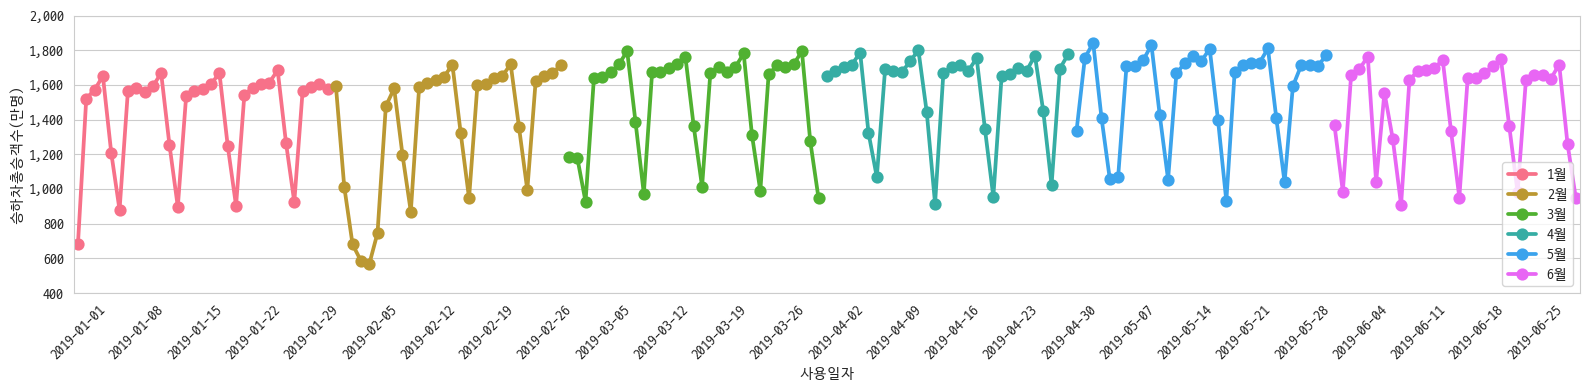

In [6]:
plt.figure(figsize=(16, 4))

df = get_df()
df['월'] = df['월'].map({i: f'{i}월' for i in range(1, 13)})

sns.pointplot(data=df, x='사용일자', y='승하차총승객수', hue='월', palette=sns.color_palette('husl', n_colors=6))

plt.ylabel('승하차총승객수(만명)')
plt.yticks(ticks=plt.yticks()[0], labels=[f'{int(y/10000):,}' for y in plt.yticks()[0]])
plt.xticks(plt.xticks()[0][::7], rotation=45)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

주차 별로 패턴이 좀 반복되는 것 같다?

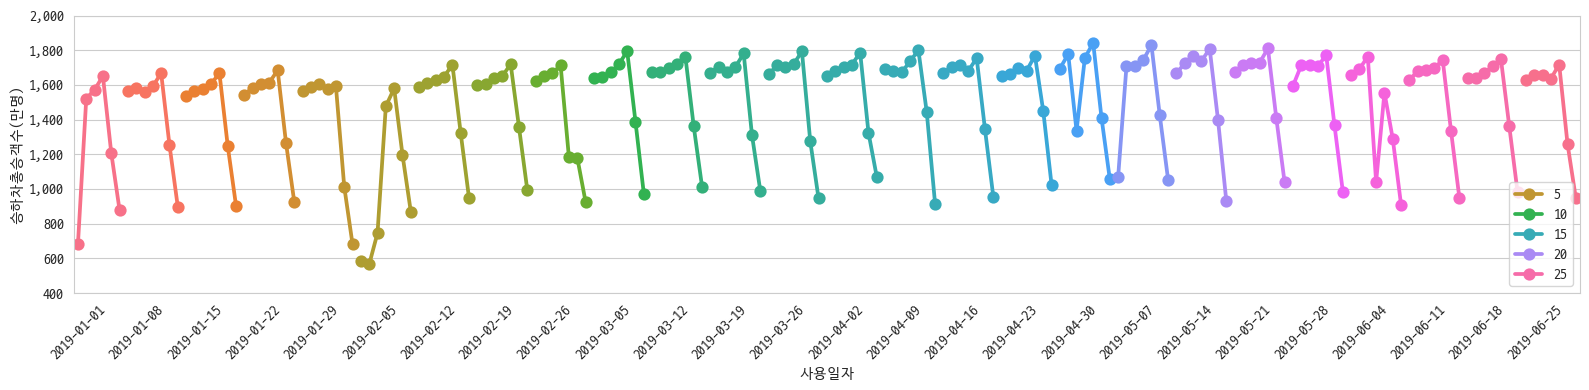

In [7]:
plt.figure(figsize=(16, 4))

df = get_df()
sns.pointplot(data=df, x='사용일자', y='승하차총승객수', hue='주차', palette='husl')

plt.ylabel('승하차총승객수(만명)')
plt.yticks(ticks=plt.yticks()[0], labels=[f'{int(y/10000):,}' for y in plt.yticks()[0]])
plt.xticks(plt.xticks()[0][::7], rotation=45)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

좀 더 직관적으로 볼 수 있는 방법을 찾아보자.

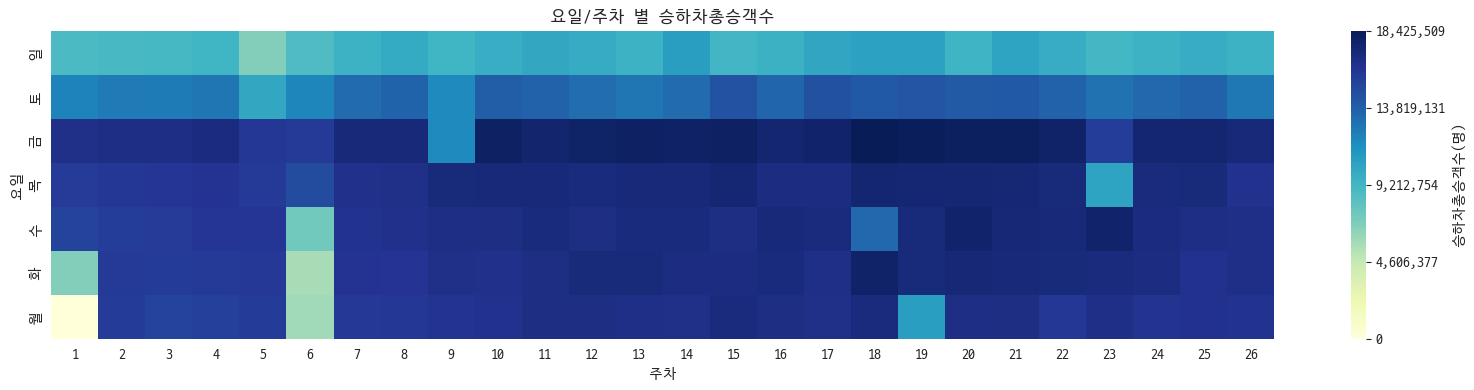

In [8]:
def display_heatmap_passengers():
    df = get_df() \
        .groupby(['주차', '요일']) \
        .aggregate({'승하차총승객수': 'sum'}) \
        .pivot_table(index='요일', columns='주차', values='승하차총승객수', fill_value=0) \
        .reindex(reversed(DAY_OF_WEEK))

    ax = sns.heatmap(data=df, cmap='YlGnBu')

    cbar = ax.collections[0].colorbar
    cbar.set_label('승하차총승객수(명)')
    cbar.set_ticks(np.linspace(df.values.min(), df.values.max(), num=5))
    cbar.set_ticklabels([f'{int(t):,}' for t in cbar.get_ticks()])


plt.figure(figsize=(16, 4))
plt.title('요일/주차 별 승하차총승객수')

display_heatmap_passengers()

plt.tight_layout()
plt.show()

혹시 공휴일과 관련이 있나?

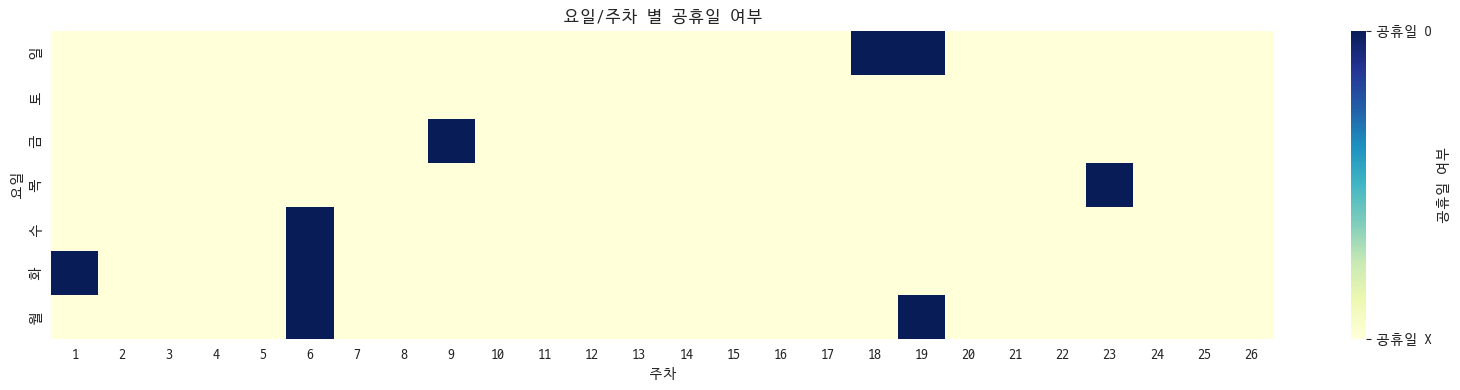

In [9]:
def display_heatmap_holidays():
    df = get_df()
    df['공휴일'] = df['공휴일'].astype(int)
    df = df.groupby(['주차', '요일']) \
        .aggregate({'공휴일': 'first'}) \
        .pivot_table(index='요일', columns='주차', values='공휴일', fill_value=0) \
        .reindex(reversed(DAY_OF_WEEK))

    ax = sns.heatmap(data=df, cmap='YlGnBu')

    cbar = ax.collections[0].colorbar
    cbar.set_label('공휴일 여부')
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['공휴일 X', '공휴일 O'])


plt.figure(figsize=(16, 4))
plt.title('요일/주차 별 공휴일 여부')

display_heatmap_holidays()

plt.tight_layout()
plt.show()

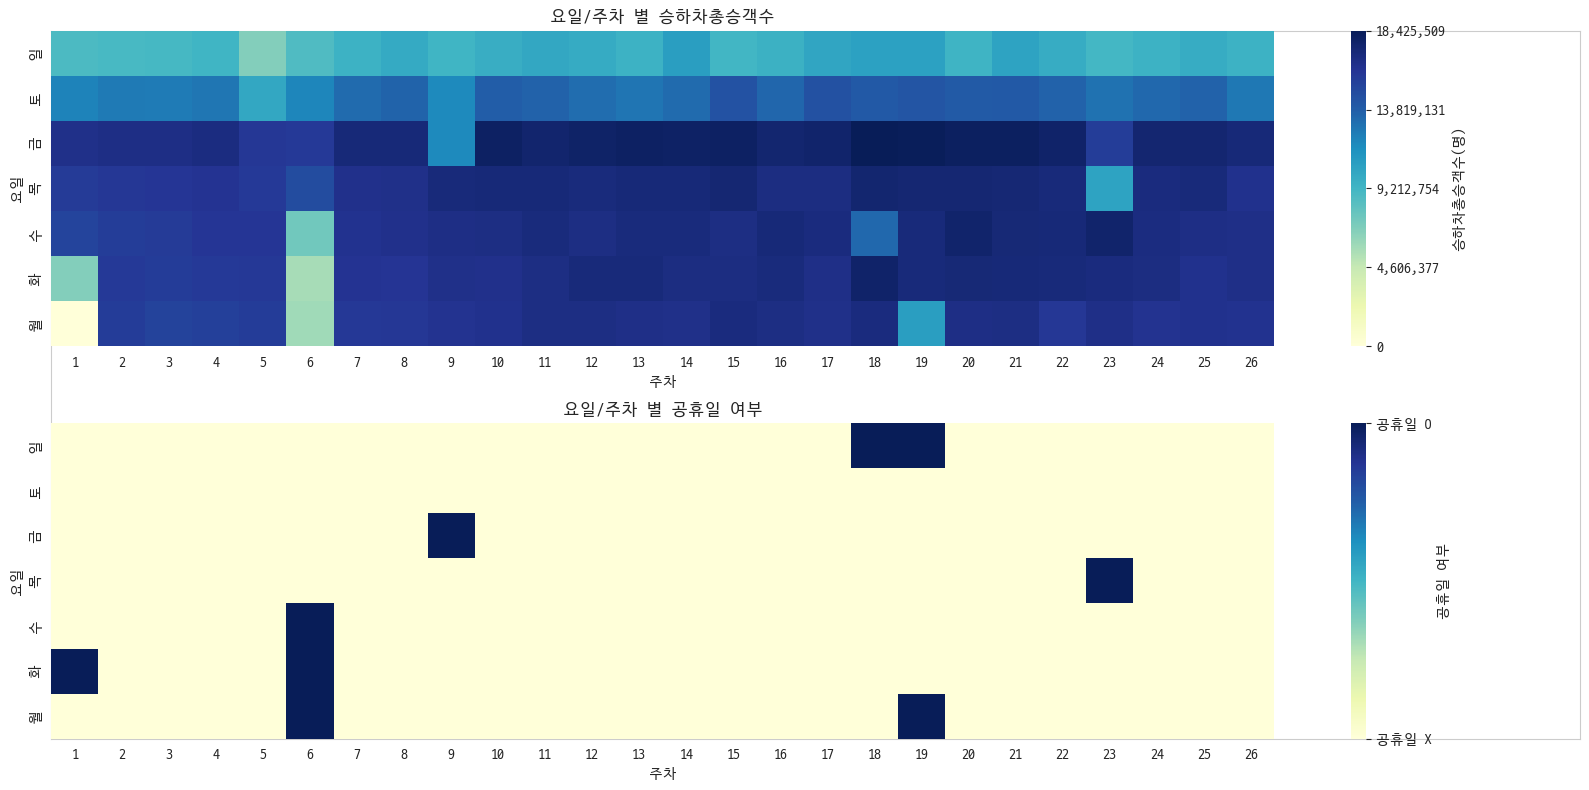

In [10]:

plt.figure(figsize=(16, 8))
plt.grid(False)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 1, 1)
plt.title('요일/주차 별 승하차총승객수')
display_heatmap_passengers()

plt.subplot(2, 1, 2)
plt.title('요일/주차 별 공휴일 여부')
display_heatmap_holidays()

plt.tight_layout()
plt.show()